In [1]:
import numpy as np
import yfinance as yf 
import pandas as pd
import matplotlib.pyplot as plt 
import scipy.optimize as optimization 

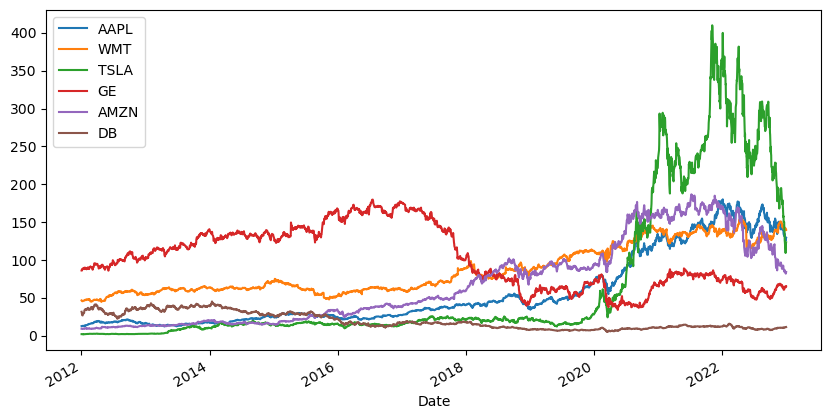

In [2]:
# Stocks we are going to handle
stocks = ['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB']
    # Apple, Walmart, Tesla, GenElectric, Amazon, Deutsche Bank

# Historical data - define START and END dates
start_date = pd.to_datetime('2012-01-01')
end_date = pd.to_datetime('2023-01-01')

# Number of trading days in a year
NUM_TRADING_DAYS = 252

# Number of portfolios to check
NUM_PORTFOLIOS = 10000


# To download the data
def download_data():
    # Name of the stock - key
    # Stock values (2010-2023) - values
    stock_data = {}

    for stock in stocks:
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(
            stock, 
            start=start_date, 
            end=end_date
        )['Close'] # We want the closing prices

    return pd.DataFrame(stock_data)

dataset = download_data()
dataset.plot(figsize=(10,5))
plt.show()

In [6]:
def calculate_returns(data):
    log_return = np.log(data/data.shift(1))
    return log_return[1:]

def generate_portfolios(returns):

    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    M = returns.cov()
    print(M)

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)

        weighted_ann_return = np.sum(returns.mean() * w) * NUM_TRADING_DAYS
        portfolio_means.append(weighted_ann_return)

        weighted_ann_volat = np.sqrt(np.dot(w.T, np.dot(M * NUM_TRADING_DAYS, w)))
        portfolio_risks.append(weighted_ann_volat)
    
    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

def show_efficient_frontier(returns, volatilities):
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities,returns, c=returns/volatilities, marker='o')
    plt.grid(True)
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.show()

In [7]:
log_daily_returns = calculate_returns(dataset)
pweights, means, risks = generate_portfolios(log_daily_returns)

          AAPL       WMT      TSLA        GE      AMZN        DB
AAPL  0.000337  0.000070  0.000239  0.000123  0.000182  0.000150
WMT   0.000070  0.000162  0.000066  0.000048  0.000064  0.000057
TSLA  0.000239  0.000066  0.001273  0.000161  0.000266  0.000214
GE    0.000123  0.000048  0.000161  0.000418  0.000104  0.000234
AMZN  0.000182  0.000064  0.000266  0.000104  0.000417  0.000147
DB    0.000150  0.000057  0.000214  0.000234  0.000147  0.000635


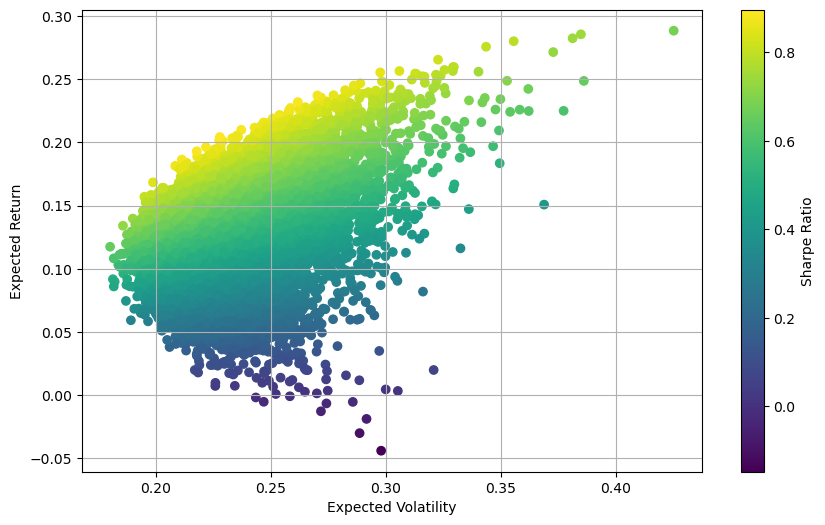

In [8]:
show_efficient_frontier(means, risks)

In [9]:
# For a given array of weights, and the existing log_daily_returns, derive the following statistics
# An array of arrays?
# 
def statistics(weights, returns):
    M = returns.cov()
    portfolio_return = np.sum(returns.mean() * weights ) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(
        np.dot(
            weights.T, 
            np.dot(M * NUM_TRADING_DAYS, weights)
            )
    ) 

    return np.array(
        [
            portfolio_return, 
            portfolio_volatility, 
            portfolio_return/portfolio_volatility
        ]
    )

def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]

def optimize_portfolio(weights, returns):
    constraints = {
        'type': 'eq',
        'fun': lambda x: np.sum(x) -1
    }
    bounds = tuple(
        (0,1) for _ in range(len(stocks))
    )

    return optimization.minimize(
        fun=min_function_sharpe,
        x0=weights[0],
        args=returns,
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraints
    )

In [10]:
optimize_portfolio(pweights, log_daily_returns)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.9139375543843983
       x: [ 3.321e-01  3.216e-01  1.776e-01  1.545e-16  1.687e-01
            3.005e-16]
     nit: 8
     jac: [ 4.713e-05  3.273e-04 -4.195e-04  5.809e-01 -2.750e-04
            1.017e+00]
    nfev: 58
    njev: 8

In [11]:
optimize_portfolio(pweights, log_daily_returns)['x'].round(3)

array([0.332, 0.322, 0.178, 0.   , 0.169, 0.   ])

In [12]:
optimum_weights = optimize_portfolio(pweights, log_daily_returns)['x'].round(3)
statistics(optimum_weights, log_daily_returns)

array([0.20536049, 0.22469862, 0.9139375 ])

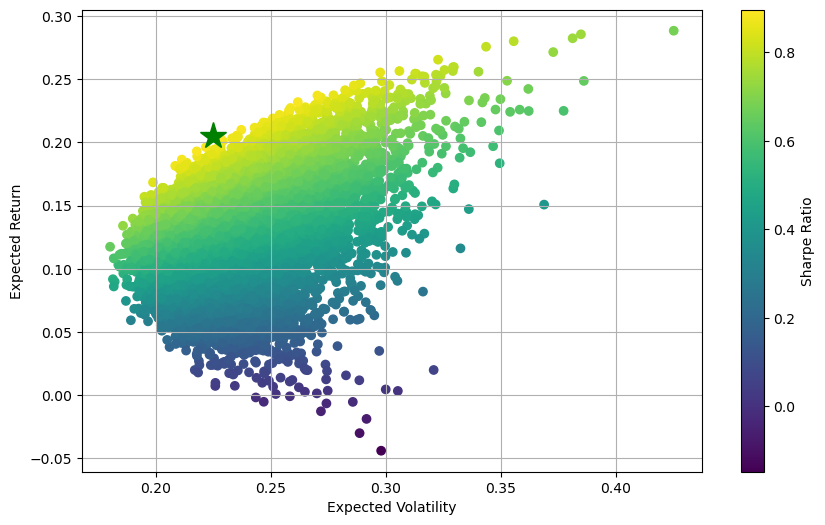

In [13]:
plt.figure(figsize=(10,6))
plt.scatter(risks, means, c=means/risks, marker='o')
plt.plot(
    statistics(optimum_weights, log_daily_returns)[1],
    statistics(optimum_weights, log_daily_returns)[0],
    'g*',
    markersize=20.0
)
plt.grid(True)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.show()

In [14]:
def print_optimal_portfolio(weights, returns):
    optimum = optimize_portfolio(weights, log_daily_returns)
    print("Optimal portfolio: ", optimum['x'].round(3))
    print("Expected return, volatility and Sharpe ratio: ",
          statistics(optimum['x'].round(3), returns))

In [15]:
print_optimal_portfolio(pweights, log_daily_returns)

Optimal portfolio:  [0.332 0.322 0.178 0.    0.169 0.   ]
Expected return, volatility and Sharpe ratio:  [0.20536049 0.22469862 0.9139375 ]
